# Astra target landing site example

## Derivation of Nozzle lift equation (fixed ascent rate)

An estimate of the bounds of Nozzle lift is required for scipy's differential evolution algorithm. We'll use a primitive approach, since the method calculates (integrates) the ascent rate equation anyway, and a penalty method will be used for ascent rates reaching outside the desired boundaries.

Force balance:

\begin{equation}
(m_{bal} + m_{pay} + m_{gas}) \frac{d^2z}{dt^2} = B - W - D = 0\\
B = W + D\\
V(\rho_{air} - \rho_{gas}) g = (m_{bal} + m_{pay})g + \frac{1}{2} \rho_{air} \left(\frac{dz}{dt}\right)^2 C_D A
\end{equation}

Then use balloon volume to get a 3rd order polynomial in terms of $r$ (assuming balloon volume is constant throughout flight, due to fixed ascent rate assumption):

\begin{equation}
\frac{4}{3} \pi (\rho_{air} - \rho_{gas}) g r^3 - \frac{1}{2} \rho_{air} \left(\frac{dz}{dt}\right)^2 C_D \pi r^2 - (m_{bal} + m_{pay})g = 0
\end{equation}

Solve for r, and extract real positive root (should be unique: otherwise, raise an error). Then use the relation of gas mass (eqn 3 in "High-Altitude Gas Balloon Trajectory Prediction: A Monte Carlo Model") to obtain the nozzle lift:

\begin{equation}
m_{gas} = \rho^0_{gas} V^0 = \rho^0_{gas} \frac{L_N/g + m_{bal}}{\rho^0_{air} - \rho^0_{gas}}\\
L_N/g = \frac{4\pi}{3} r^3 (\rho_{air}-\rho_{gas}) - m_{bal} \hspace{1em} (kg)
\end{equation}

This is found in ```astra.flight_tools.nozzleLiftFixedAscent```, and has been validated with [habhub](http://habhub.org/calc/), which gives nozzle lift values of the same magnitude, and similar value (+- 10%)

## 2D Optimization: Time + Nozzle Lift

In [1]:
%load_ext autoreload
%autoreload
import astra
from astra.target_landing import targetFlight
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import interp1d
from astra.weather import forecastEnvironment
from astra.GFS import GFS_Handler
import astra
import os
%matplotlib notebook



In [2]:
targetLat = 51.34476756
targetLon = -1.46976471
targetElev = 188

# Use a previous forecast (allows offline development)
launch_datetime = datetime.today() + timedelta(days=1)
simEnvironment = forecastEnvironment(launchSiteLat=50.903824,      # deg
                                     launchSiteLon=-1.63697,     # deg
                                     launchSiteElev=114.0,           # m
                                     dateAndTime=launch_datetime,
                                     forceNonHD=True,
                                     debugging=True)
# # Set up the example input data files (from 24/04/2017, Daytona Beach)
# fileDict = {}
# for paramName in GFS_Handler.weatherParameters.keys():
#     fileDict[paramName] = os.path.join(os.path.dirname(astra.__file__),
#         '../test/example_data',
#         'gfs_0p50_06z.ascii?{}[12:15][0:46][231:245][545:571]'.format(paramName))
# simEnvironment.loadFromNOAAFiles(fileDict)
# inputs = {'launchSiteForecasts': [simEnvironment]}

simulator = targetFlight(start_dateTime=launch_datetime,
                 targetLat=targetLat,
                 targetLon=targetLon,
                 targetElev=targetElev,
                 launchSites=[(50.903824, -1.63697, 114.0)],
                 balloonModel='TA100',
                 balloonGasType="Helium",
                 nozzleLift=1,
                 trainEquivSphereDiam=0.1,
                 inflationTemperature=0.0,
                 payloadTrainWeight=0.38,
                 windowDuration=72,
                 HD=False,
                 maxFlightTime=18000,
                 parachuteModel=None,
                 debugging=False,
                 log_to_file=False,
                 progress_to_file=False,
                 outputFile=os.path.join(''))

In [7]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import copy
bestProfile_bf, X, Y, distances = simulator.bruteForce()
results_bf = copy.deepcopy(simulator.results)

INFO:astra.target_landing:Date range: [2017-06-16 10:32:16.362543, 2017-06-19 10:32:16.362543], Nx=19 points
INFO:astra.target_landing:Nozzle Lift range: [0.41604821396915026, 1.7128711861717523] (kg), Ny=21 points
DEBUG:astra.target_landing:Running brute force calculation
DEBUG:astra.target_landing:Running flight for datetime 2017-06-16 10:32:16.362543, nozzleLift=0.41604821396915026kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-16 10:32:16.362543, nozzleLift=0.4808893625792804kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-16 10:32:16.362543, nozzleLift=0.5457305111894104kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-16 10:32:16.362543, nozzleLift=0.6105716597995405kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-16 10:32:16.362543, nozzleLift=0.6754128084096707kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-16 10:32:16.362543, nozzleLift=0.7402539570198008kg
DEBUG:astra.target_landing:Running 

DEBUG:astra.target_landing:Running flight for datetime 2017-06-16 22:32:16.362543, nozzleLift=0.8050951056299309kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-16 22:32:16.362543, nozzleLift=0.8699362542400609kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-16 22:32:16.362543, nozzleLift=0.9347774028501911kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-16 22:32:16.362543, nozzleLift=0.9996185514603212kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-16 22:32:16.362543, nozzleLift=1.0644597000704512kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-16 22:32:16.362543, nozzleLift=1.1293008486805813kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-16 22:32:16.362543, nozzleLift=1.1941419972907115kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-16 22:32:16.362543, nozzleLift=1.2589831459008416kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-16 22:32:16.36254

DEBUG:astra.target_landing:Running flight for datetime 2017-06-17 10:32:16.362543, nozzleLift=1.3886654431211016kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-17 10:32:16.362543, nozzleLift=1.453506591731232kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-17 10:32:16.362543, nozzleLift=1.5183477403413619kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-17 10:32:16.362543, nozzleLift=1.5831888889514922kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-17 10:32:16.362543, nozzleLift=1.6480300375616221kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-17 10:32:16.362543, nozzleLift=1.7128711861717523kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-17 14:32:16.362543, nozzleLift=0.41604821396915026kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-17 14:32:16.362543, nozzleLift=0.4808893625792804kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-17 14:32:16.36254

DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 02:32:16.362543, nozzleLift=0.6105716597995405kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 02:32:16.362543, nozzleLift=0.6754128084096707kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 02:32:16.362543, nozzleLift=0.7402539570198008kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 02:32:16.362543, nozzleLift=0.8050951056299309kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 02:32:16.362543, nozzleLift=0.8699362542400609kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 02:32:16.362543, nozzleLift=0.9347774028501911kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 02:32:16.362543, nozzleLift=0.9996185514603212kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 02:32:16.362543, nozzleLift=1.0644597000704512kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 02:32:16.36254

DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 14:32:16.362543, nozzleLift=1.1941419972907115kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 14:32:16.362543, nozzleLift=1.2589831459008416kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 14:32:16.362543, nozzleLift=1.3238242945109717kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 14:32:16.362543, nozzleLift=1.3886654431211016kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 14:32:16.362543, nozzleLift=1.453506591731232kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 14:32:16.362543, nozzleLift=1.5183477403413619kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 14:32:16.362543, nozzleLift=1.5831888889514922kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 14:32:16.362543, nozzleLift=1.6480300375616221kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 14:32:16.362543

DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 06:32:16.362543, nozzleLift=0.41604821396915026kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 06:32:16.362543, nozzleLift=0.4808893625792804kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 06:32:16.362543, nozzleLift=0.5457305111894104kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 06:32:16.362543, nozzleLift=0.6105716597995405kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 06:32:16.362543, nozzleLift=0.6754128084096707kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 06:32:16.362543, nozzleLift=0.7402539570198008kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 06:32:16.362543, nozzleLift=0.8050951056299309kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 06:32:16.362543, nozzleLift=0.8699362542400609kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 06:32:16.3625

In [ ]:
np.shape(simulator.)

In [ ]:
%autoreload
import astra

<IPython.core.display.Javascript object>


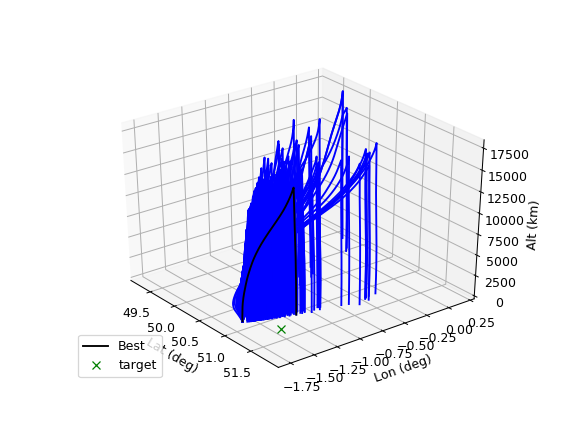

(<matplotlib.figure.Figure at 0x7f3b121a42b0>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7f3b00988c88>)

In [10]:
# Visualise the best result paths
simulator.plotPaths3D()

(19,) (21,) (19, 21)


<IPython.core.display.Javascript object>


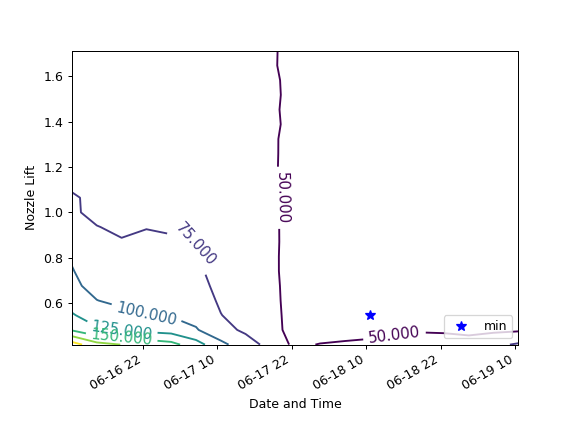

In [9]:
# fig1, ax1 = simulator.plotPaths3D()

# fig2, ax2 = simulator.plotLandingSites()
simulator.results = results_bf
simulator.bestProfile = bestProfile_bf
print(np.shape(X), np.shape(Y), np.shape(distances))
fig3, ax3 = simulator.plotLandingSiteDistanceContours(X, Y, distances.T)


In [11]:
print(bestProfile_bf.latitudeProfile[-1], bestProfile_bf.longitudeProfile[-1])

51.12583515759789 -1.1777914570041577


In [ ]:
%autoreload
import astra

In [ ]:
# Optimize with Scipy:
res = simulator.optimizeTargetLandingSite(x0=[0.3*simulator.windowDuration], options={"disp": True})
bestProfile_scipy = simulator.bestProfile
results_scipy = simulator.results

In [ ]:
# Optimize with scipy differential evolution
simulator.bestProfile = bestProfile_scipy
simulator.results = results_scipy
simulator.plotLandingSiteDistances(fig3, ax3, marker='rx', bestMarker='r*', appendLabel=' Nelder-Mead')

## Scipy differential Evolution

In [ ]:
res = simulator.optimizeTargetLandingSite(method='DE')
results_de = simulator.results
bestProfile_de = simulator.bestProfile

In [ ]:
simulator.results = results_de
simulator.bestProfile = bestProfile_de
simulator.plotLandingSiteDistances(fig3, ax3, marker='kx', bestMarker='k*', appendLabel=' DE')

In [ ]:
fig3.savefig('Distance_vs_datetime_1d_comparison.pdf')

In [ ]:
from astra import flight_tools as ftools
nozzleLift = ftools.nozzleLiftFixedAscent(1.5, simulator._balloonWeight, simulator.payloadTrainWeight, simulator.environment.inflationTemperature,
    simulator.environment.getPressure(simulator.launchSiteLat,
                                             simulator.launchSiteLon,
                                             simulator.launchSiteElev,
                                             simulator.start_dateTime),
    simulator._gasMolecularMass, simulator.excessPressureCoeff, (0.225 + 0.425)/2.)


print(nozzleLift)

In [ ]:
(0.225 + 0.425)/2.

In [ ]:
import scipy.optimize

res = scipy.optimize.minimize(f_curve, x0=[0.3*simulator.windowDuration], method='Nelder-Mead',
#                               bounds=[(0.1, simulator.windowDuration-0.1)],
                             options={"disp": True})
best_time_model = simulator.start_dateTime + timedelta(hours=res.x[0])
# res.fun
ax.plot(best_time_model, res.fun, '^r', label=r'Nelder-Mead, $x_0=0.3 \times dt$')

res = scipy.optimize.minimize(f_curve, x0=[0.7*simulator.windowDuration], method='BFGS',
#                               bounds=[(0.1, simulator.windowDuration-0.1)],
                             options={"disp": True})
best_time_model = simulator.start_dateTime + timedelta(hours=res.x[0])
# res.fun
ax.plot(best_time_model, res.fun, 'or', label=r'Nelder-Mead, $x_0=0.7 \times dt$')

In [ ]:
import scipy.optimize

res = scipy.optimize.differential_evolution(f_curve,
                              bounds=[(0.1, simulator.windowDuration-0.1)],
                              polish=False)
best_time_de = simulator.start_dateTime + timedelta(hours=res.x[0])
# res.fun
ax.plot(best_time_de, res.fun, '^g', label='DE')
print(res.nit)
lgd = ax.legend(loc='upper left')
ax.set_facecolor("white")
plt.tight_layout()
fig.savefig('brute_force_comparison.png', bbox_extra_artists=(lgd,), bbox_inches='tight')


## Testing

In [ ]:
 datetimeVector = [self.start_dateTime + timedelta(hours=t)
                            for t in range(self.windowDuration)]

nozzleLiftLowerBound = 0.4
nozzleLiftUpperBound = 1.0
nozzelLift_Vector = np.linspace(nozzleLiftLowerBound, nozzleLiftUpperBound)
self.results = {}

distance_map = {}
for i, launchSiteForecast in enumerate(self.launchSiteForecasts):
    self.environment = launchSiteForecast

    for j, t in enumerate(datetimeVector):
        distance_lift_vec = np.zeros(np.length(nozzelLift_Vector))
        for k, L in enumerate(nozzelLift_Vector):
            # brute force approach
            distance = self.targetDistance(t)
            distance_lift_vec[k] = distance

        distance_map[t] = distance_Vector  